In [1]:
import sys, os
import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

from sklearn.decomposition import PCA
from umap import UMAP

In [2]:
import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch

from sklearn.preprocessing import StandardScaler

In [3]:
# class NewModel(Module):
#     def __init__(self, dir = "../data/simulated/2b3c_ziqi1/", N=3, batch_size=512, interval=10, lr=1e-3, init='svd'):
#         super().__init__()
#         self.N = N
#         self.batch_size = batch_size
#         self.interval = interval
#         self.alpha = torch.FloatTensor([1000, 1000, 1000, 1])
#         # data
#         counts_rna = pd.read_csv(dir + "GxC1.txt", sep = "\t", header = None).values.T
#         counts_atac = pd.read_csv(dir + "RxC2.txt", sep = "\t", header = None).values.T
#         gact = pd.read_csv(dir + "region2gene.txt", sep = "\t", header = None).values.T

#         counts_rna = utils.preprocess(counts_rna, mode = "quantile", modality = "RNA")
#         counts_atac = utils.preprocess(counts_atac, mode = "quantile", modality = "ATAC")
#         gact = utils.preprocess(gact, mode = "gact")

#         self.G = torch.FloatTensor(counts_rna)
#         self.R = torch.FloatTensor(counts_atac)
#         self.A = torch.FloatTensor(gact)

#         self.s_g = Parameter(torch.ones(1, self.G.shape[1]))
#         self.s_r = Parameter(torch.ones(1, self.R.shape[1]))
# #         self.s_g = torch.ones(1, self.G.shape[1])
# #         self.s_r = torch.ones(1, self.R.shape[1])
        
#         # 
#         self.b_g = Parameter(torch.zeros(1, self.G.shape[1]))
#         self.b_r = Parameter(torch.zeros(1, self.R.shape[1]))
# #         self.b_g = torch.zeros(1, self.G.shape[1])
# #         self.b_r = torch.zeros(1, self.R.shape[1])
#         self.C_1 = Parameter(torch.randn(self.G.shape[0], N))
#         self.C_2 = Parameter(torch.randn(self.R.shape[0], N))
#         self.C_g = Parameter(torch.randn(self.G.shape[1], N))
#         self.C_r = Parameter(torch.randn(self.R.shape[1], N))

#         self.meta_rna = pd.read_csv(os.path.join(dir, "cell_label1.txt"), sep = "\t")
#         self.meta_atac = pd.read_csv(os.path.join(dir, "cell_label2.txt"), sep = "\t")

#         self.optimizer = opt.Adam(self.parameters(), lr=lr)

#         with torch.no_grad():
#             loss, *_ = self.batch_loss('valid')
#             print('Initial Loss is {:.5f}'.format(loss.item()))

#     @staticmethod
#     def softmax(X: torch.Tensor):
#         return torch.softmax(X, dim=1)

#     @staticmethod
#     def entropy_loss(C):
#         loss = - F.softmax(C, dim=1) * F.log_softmax(C, dim=1)
#         return loss.sum(dim=1).mean()

#     def batch_loss(self, mode='C_c'):
#         if mode != 'valid':
#             mask_1 = np.random.choice(self.G.shape[0], self.batch_size, replace=False)
#             mask_2 = np.random.choice(self.R.shape[0], self.batch_size, replace=False)
#             mask_g = np.random.choice(self.G.shape[1], self.batch_size, replace=False)
#             mask_r = np.random.choice(self.R.shape[1], self.batch_size, replace=False)

#         if mode == 'C_12':
#             loss1 = (self.G[np.ix_(mask_1, mask_g)] - self.s_g[:, mask_g] * (self.softmax(self.C_1[mask_1,:]) @
#                      self.softmax(self.C_g[mask_g,:].detach()).t()) - self.b_g[:, mask_g]).pow(2).mean()
#             loss2 = (self.R[np.ix_(mask_2, mask_r)] - self.s_r[:, mask_r] * (self.softmax(self.C_2[mask_2,:]) @
#                      self.softmax(self.C_r[mask_r,:].detach()).t()) - self.b_r[:, mask_r]).pow(2).mean()
#             loss3, loss4 = 0, 0
        
#         elif mode == 'C_gr':
#             loss1 = (self.G[np.ix_(mask_1, mask_g)] - self.s_g[:, mask_g] * (self.softmax(self.C_1[mask_1,:].detach()) @
#                      self.softmax(self.C_g[mask_g, :]).t()) - self.b_g[:, mask_g]).pow(2).mean()
#             loss2 = (self.R[np.ix_(mask_2, mask_r)] - self.s_r[:, mask_r] * (self.softmax(self.C_2[mask_2,:].detach()) @
#                      self.softmax(self.C_r[mask_r, :]).t()) - self.b_r[:, mask_r]).pow(2).mean()
#             loss3 = (self.A[np.ix_(mask_g, mask_r)].t() @ self.softmax(self.C_g[mask_g,:]) - self.softmax(self.C_r[mask_r,:])).pow(2).mean()
#             loss4 = self.entropy_loss(self.C_g[mask_g]) + self.entropy_loss(self.C_r[mask_g])
   
#         elif mode == 'valid':
#             with torch.no_grad():
#                 loss1 = (self.G - self.s_g * (self.softmax(self.C_1) @
#                          self.softmax(self.C_g).t()) - self.b_g).pow(2).mean()
#                 loss2 = (self.R - self.s_r * (self.softmax(self.C_2.detach()) @
#                          self.softmax(self.C_r).t()) - self.b_r).pow(2).mean()
#                 loss3 = (self.A.t() @ self.softmax(self.C_g) - self.softmax(self.C_r)).pow(2).mean()
#                 loss4 = self.entropy_loss(self.C_g) + self.entropy_loss(self.C_r)
#         else:
#             raise NotImplementedError
#         loss = self.alpha[0] * loss1 + self.alpha[1] * loss2 + self.alpha[2] * loss3 + self.alpha[3] * loss4

#         return loss, self.alpha[0] * loss1, self.alpha[1] * loss2, self.alpha[2] * loss3, self.alpha[3] * loss4
#     #
#     def train_func(self, T):
#         best_loss = 1e12
#         count = 0
#         for t in range(T):
#             self.optimizer.zero_grad()
#             # for mode in ['C_c']:
#             for mode in ['C_12', 'C_gr', 'C_12', 'C_gr']:
#                 loss, *_ = self.batch_loss(mode)
#                 loss.backward()
#                 self.optimizer.step()
#             if (t+1) % self.interval == 0:
#                 loss, loss1, loss2, loss3, loss4 = self.batch_loss('valid')
#                 print('Epoch {}, Validating Loss: {:.4f}'.format(t + 1, loss.item()))
#                 info = [
#                     'loss RNA: {:.5f}'.format(loss1.item()),
#                     'loss ATAC: {:.5f}'.format(loss2.item()),
#                     'loss gene act: {:.5f}'.format(loss3.item()),
#                     'loss sparse: {:.5f}'.format(loss4.item()),
#                 ]
#                 for i in info:
#                     print("\t", i)
#                 if loss.item() < best_loss:
#                     best_loss = loss.item()
#                     torch.save(self.state_dict(), f'../check_points/real_{self.N}.pt')
#                     count = 0
#                 else:
#                     count += 1
#                     if count % 20 == 0:
#                         self.optimizer.param_groups[0]['lr'] *= 0.5
#                         print('Epoch: {}, shrink lr to {:.4f}'.format(t + 1, self.optimizer.param_groups[0]['lr']))
#                         if self.optimizer.param_groups[0]['lr'] < 1e-4:
#                             break
#                         else:
#                             self.load_state_dict(torch.load(f'../check_points/real_{self.N}.pt'))
#                             count = 0



In [10]:
class NewModel(Module):
    def __init__(self, dir = "../data/simulated/2b3c_ziqi1/", N=3, batch_size=512, interval=10, lr=1e-3, init='svd'):
        super().__init__()
        self.N = N
        self.batch_size = batch_size
        self.interval = interval
        # self.alpha = torch.FloatTensor([1000, 1000, 1000, 1])
        self.alpha = torch.FloatTensor([10, 1000, 1, 1])
        # data
        counts_rna = pd.read_csv(dir + "GxC1.txt", sep = "\t", header = None).values.T
        counts_atac = pd.read_csv(dir + "RxC2.txt", sep = "\t", header = None).values.T
        gact = pd.read_csv(dir + "region2gene.txt", sep = "\t", header = None).values.T

        counts_rna = utils.preprocess(counts_rna, mode = "quantile", modality = "RNA")
        counts_atac = utils.preprocess(counts_atac, mode = "quantile", modality = "ATAC")
        gact = utils.preprocess(gact, mode = "gact")

        # non-negative, don't use standard scaler
        counts_rna = counts_rna/np.max(counts_rna)
        counts_atac = counts_atac/np.max(counts_atac)

        self.G = torch.FloatTensor(counts_rna)
        self.R = torch.FloatTensor(counts_atac)
        self.A = torch.FloatTensor(gact)

        self.Ar = Parameter(torch.randn((N,N)))
        self.Ag = Parameter(torch.randn((N,N)))

        self.C_1 = Parameter(torch.randn(self.G.shape[0], N))
        self.C_2 = Parameter(torch.randn(self.R.shape[0], N))
        # replace C_2 with P @ C_1, where P is a simplex pairing matrix, then C_2 is still simplex
        self.P = Parameter(torch.randn(self.G.shape[0], self.R.shape[0]))
        
        self.C_g = Parameter(torch.randn(self.G.shape[1], N))
        self.C_r = Parameter(torch.randn(self.R.shape[1], N))

        self.b_g = torch.zeros(1, self.G.shape[1])
        self.b_r = torch.zeros(1, self.R.shape[1])    

        self.meta_rna = pd.read_csv(os.path.join(dir, "cell_label1.txt"), sep = "\t")
        self.meta_atac = pd.read_csv(os.path.join(dir, "cell_label2.txt"), sep = "\t")

        self.optimizer = opt.Adam(self.parameters(), lr=lr)

        with torch.no_grad():
            loss, *_ = self.batch_loss('valid')
            print('Initial Loss is {:.5f}'.format(loss.item()))

    @staticmethod
    def softmax(X: torch.Tensor):
        return torch.softmax(X, dim=1)
        # return X
        # return torch.exp(X)

    @staticmethod
    def entropy_loss(C):
        loss = - F.softmax(C, dim=1) * F.log_softmax(C, dim=1)
        return loss.sum(dim=1).mean()

    def batch_loss(self, mode='C_c'):
        if mode != 'valid':
            mask_1 = np.random.choice(self.G.shape[0], self.batch_size, replace=False)
            mask_2 = np.random.choice(self.R.shape[0], self.batch_size, replace=False)
            mask_g = np.random.choice(self.G.shape[1], self.batch_size, replace=False)
            mask_r = np.random.choice(self.R.shape[1], self.batch_size, replace=False)
            
        if mode == 'C_12':
            loss1 = (self.G[np.ix_(mask_1, mask_g)] - (self.softmax(self.P[np.ix_(mask_1, mask_2)]) @ 
                     self.softmax(self.C_2[mask_2,:]) @ self.Ar.detach() @
                     self.softmax(self.C_g[mask_g,:].detach()).t()) - self.b_g[:, mask_g]).pow(2).mean()
            # original ver
            loss2 = (self.R[np.ix_(mask_2, mask_r)] - (self.softmax(self.C_2[mask_2,:]) @ self.Ag.detach() @
                     self.softmax(self.C_r[mask_r,:].detach()).t()) - self.b_r[:, mask_r]).pow(2).mean()
            
            # pairing ver
            # loss2 = (self.R[np.ix_(mask_2, mask_r)] - (self.softmax(self.C_2[mask_1,:])@ self.Ag.detach() @
            #          self.softmax(self.C_r[mask_r,:].detach()).t()) - self.b_r[:, mask_r]).pow(2).mean()
            
            loss3 = 0
            loss4 = 0 # self.entropy_loss(self.C_1[mask_1, :]) + self.entropy_loss(self.C_2[mask_2,:])

        elif mode == 'C_gr':
            loss1 = (self.G[np.ix_(mask_1, mask_g)] - (self.softmax(self.P[np.ix_(mask_1, mask_2)].detach()) @
                     self.softmax(self.C_2[mask_2,:].detach()) @ self.Ar.detach() @
                     self.softmax(self.C_g[mask_g, :]).t()) - self.b_g[:, mask_g]).pow(2).mean()
            
            # original ver
            loss2 = (self.R[np.ix_(mask_2, mask_r)] - (self.softmax(self.C_2[mask_2,:].detach()) @ self.Ag.detach() @
                     self.softmax(self.C_r[mask_r, :]).t()) - self.b_r[:, mask_r]).pow(2).mean()
            
            # pairing ver
            # loss2 = (self.R[np.ix_(mask_2, mask_r)] - (self.softmax(self.P[np.ix_(mask_2, mask_1)]).detach() @ 
            #          self.softmax(self.C_1[mask_1,:]).detach()@ self.Ag.detach() @
            #          self.softmax(self.C_r[mask_r,:]).t()) - self.b_r[:, mask_r]).pow(2).mean()            
            
            # original ver
            # loss3 = (self.softmax(self.C_g[mask_g,:]) - self.A[np.ix_(mask_g, mask_r)] @ 
            #          self.softmax(self.C_r[mask_r,:])).pow(2).mean()
            
            # correlation ver
            loss3 = -torch.trace(self.softmax(self.C_g[mask_g,:]).t() @ self.A[np.ix_(mask_g, mask_r)] @ 
                      self.softmax(self.C_r[mask_r,:]))
            loss4 = 0 # self.entropy_loss(self.C_g[mask_g]) + self.entropy_loss(self.C_r[mask_g])
        
        elif mode == "A":
            loss1 = (self.G[np.ix_(mask_1, mask_g)] - (self.softmax(self.P[np.ix_(mask_1, mask_2)].detach()) @
                     self.softmax(self.C_2[mask_2,:].detach()) @ self.Ar @
                     self.softmax(self.C_g[mask_g, :].detach()).t()) - self.b_g[:, mask_g]).pow(2).mean()
            
            # original ver
            loss2 = (self.R[np.ix_(mask_2, mask_r)] - (self.softmax(self.C_2[mask_2,:].detach()) @ self.Ag @
                     self.softmax(self.C_r[mask_r, :].detach()).t()) - self.b_r[:, mask_r]).pow(2).mean()
            
            # pairing ver
            # loss2 = (self.R[np.ix_(mask_2, mask_r)] - (self.softmax(self.P[np.ix_(mask_2, mask_1)]).detach() @ 
            #          self.softmax(self.C_1[mask_1,:]).detach()@ self.Ag @
            #          self.softmax(self.C_r[mask_r,:].detach()).t()) - self.b_r[:, mask_r]).pow(2).mean()  
            
            loss3 = 0
            loss4 = (self.Ar - self.Ag).pow(2).mean()
            # self.entropy_loss(self.C_g[mask_g]) + self.entropy_loss(self.C_r[mask_g])
            
   
        elif mode == 'valid':
            with torch.no_grad():
                loss1 = (self.G - (self.softmax(self.P) @ self.softmax(self.C_2) @ self.Ar @
                         self.softmax(self.C_g).t()) - self.b_g).pow(2).mean()
                
                # original ver
                loss2 = (self.R - (self.softmax(self.C_2) @ self.Ar @
                         self.softmax(self.C_r).t()) - self.b_r).pow(2).mean()
                
                # pairing ver
                # loss2 = (self.R - (self.softmax(self.P) @ self.softmax(self.C_1)@ self.Ag @
                #          self.softmax(self.C_r).t()) - self.b_r).pow(2).mean()                  
                
                # update, should be correlationship instead of mse, which makes it into the coupledNMF term
                # loss3 = (self.softmax(self.C_g) - self.A @ self.softmax(self.C_r)).pow(2).mean()
                
                # maximize the correlationship
                loss3 = -torch.trace(self.softmax(self.C_g).t() @ self.A @ self.softmax(self.C_r))
                
                loss4 = (self.Ar - self.Ag).pow(2).mean()
                # self.entropy_loss(self.C_g) + self.entropy_loss(self.C_r)
        else:
            raise NotImplementedError
        loss = self.alpha[0] * loss1 + self.alpha[1] * loss2 + self.alpha[2] * loss3 + self.alpha[3] * loss4

        return loss, self.alpha[0] * loss1, self.alpha[1] * loss2, self.alpha[2] * loss3, self.alpha[3] * loss4
    #
    def train_func(self, T):
        best_loss = 1e12
        count = 0
        for t in range(T):
            loss = 0
            for it in range(500):
                mode = 'C_12'
                self.optimizer.zero_grad()
                loss_pre = loss
                loss, *_ = self.batch_loss(mode)
                loss.backward()
                self.optimizer.step()
                if torch.abs(loss_pre - loss) < 1e-3:
                    print(it)
                    break
                    
#             with torch.no_grad():
#                 self.C_1.copy_(torch.qr(self.C_1)[0])
#                 self.C_2.copy_(torch.qr(self.C_2)[0])
            
            loss = 0
            for it in range(500):
                mode = 'C_gr'
                self.optimizer.zero_grad()
                loss_pre = loss
                loss, *_ = self.batch_loss(mode)
                loss.backward()
                self.optimizer.step()
                if torch.abs(loss_pre - loss) < 1e-3:
                    print(it)
                    break
                    
#             with torch.no_grad():
#                 self.C_g.copy_(torch.qr(self.C_g)[0])
#                 self.C_r.copy_(torch.qr(self.C_r)[0])


            for it in range(500):
                mode = 'A'
                self.optimizer.zero_grad()
                loss_pre = loss
                loss, *_ = self.batch_loss(mode)
                loss.backward()
                self.optimizer.step()
                if torch.abs(loss_pre - loss) < 1e-3:
                    print(it)
                    break
                    
                
            if (t+1) % self.interval == 0:
                loss, loss1, loss2, loss3, loss4 = self.batch_loss('valid')
                print('Epoch {}, Validating Loss: {:.4f}'.format(t + 1, loss.item()))
                info = [
                    'loss RNA: {:.5f}'.format(loss1.item()),
                    'loss ATAC: {:.5f}'.format(loss2.item()),
                    'loss gene act: {:.5f}'.format(loss3.item()),
                    'loss sparse: {:.5f}'.format(loss4.item()),
                ]
                for i in info:
                    print("\t", i)
                if loss.item() < best_loss:
                    best_loss = loss.item()
                    torch.save(self.state_dict(), f'../check_points/real_{self.N}.pt')
                    count = 0
                else:
                    count += 1
                    if count % 20 == 0:
                        self.optimizer.param_groups[0]['lr'] *= 0.5
                        print('Epoch: {}, shrink lr to {:.4f}'.format(t + 1, self.optimizer.param_groups[0]['lr']))
                        if self.optimizer.param_groups[0]['lr'] < 1e-4:
                            break
                        else:
                            self.load_state_dict(torch.load(f'../check_points/real_{self.N}.pt'))
                            count = 0



In [11]:
model = NewModel(dir = '../data/simulated/2b5c_ziqi1/', N = 5, batch_size = 64, interval = 1, lr = 1e-3, init = "random")
model.train_func(T=100)

Initial Loss is -16.04893
Epoch 1, Validating Loss: -120.2669
	 loss RNA: 0.92736
	 loss ATAC: 150.46103
	 loss gene act: -273.10599
	 loss sparse: 1.45071
Epoch 2, Validating Loss: -111.9526
	 loss RNA: 0.44442
	 loss ATAC: 161.33136
	 loss gene act: -274.43747
	 loss sparse: 0.70912
Epoch 3, Validating Loss: -117.2793
	 loss RNA: 0.39185
	 loss ATAC: 158.27017
	 loss gene act: -276.20459
	 loss sparse: 0.26329
408
Epoch 4, Validating Loss: -117.5992
	 loss RNA: 0.37914
	 loss ATAC: 160.53891
	 loss gene act: -278.62885
	 loss sparse: 0.11165
Epoch 5, Validating Loss: -120.1900
	 loss RNA: 0.38046
	 loss ATAC: 160.70160
	 loss gene act: -281.35898
	 loss sparse: 0.08694
Epoch 6, Validating Loss: -126.4558
	 loss RNA: 0.38606
	 loss ATAC: 156.87367
	 loss gene act: -283.80264
	 loss sparse: 0.08707
Epoch 7, Validating Loss: -134.8203
	 loss RNA: 0.39313
	 loss ATAC: 150.41527
	 loss gene act: -285.71890
	 loss sparse: 0.09025
Epoch 8, Validating Loss: -142.8366
	 loss RNA: 0.40236
	 lo

Epoch 64, Validating Loss: -269.8851
	 loss RNA: 0.31107
	 loss ATAC: 48.00660
	 loss gene act: -318.20523
	 loss sparse: 0.00245
Epoch 65, Validating Loss: -271.0449
	 loss RNA: 0.31011
	 loss ATAC: 47.99123
	 loss gene act: -319.34851
	 loss sparse: 0.00230
Epoch 66, Validating Loss: -272.0188
	 loss RNA: 0.30905
	 loss ATAC: 48.04813
	 loss gene act: -320.37827
	 loss sparse: 0.00226
Epoch 67, Validating Loss: -273.3541
	 loss RNA: 0.30873
	 loss ATAC: 47.71014
	 loss gene act: -321.37509
	 loss sparse: 0.00213
Epoch 68, Validating Loss: -274.0188
	 loss RNA: 0.30753
	 loss ATAC: 47.40954
	 loss gene act: -321.73801
	 loss sparse: 0.00210
Epoch 69, Validating Loss: -274.6364
	 loss RNA: 0.30646
	 loss ATAC: 47.44444
	 loss gene act: -322.38953
	 loss sparse: 0.00221
Epoch 70, Validating Loss: -275.0948
	 loss RNA: 0.30559
	 loss ATAC: 47.35256
	 loss gene act: -322.75519
	 loss sparse: 0.00225
Epoch 71, Validating Loss: -275.8924
	 loss RNA: 0.30463
	 loss ATAC: 47.55581
	 loss gene

In [12]:
# torch.save(model, "b2c6.pth")
# model = torch.load("b2c6.pth")
from umap import UMAP

pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z_rna = model.softmax(model.C_1.detach()).numpy()
z_atac = model.softmax(model.C_2.detach()).numpy()

max_rna = np.argmax(z_rna, axis = 1)
max_atac = np.argmax(z_atac, axis = 1)

z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = model.meta_rna["pop"].values[:,None]
label_atac = model.meta_atac["pop"].values[:,None]

None


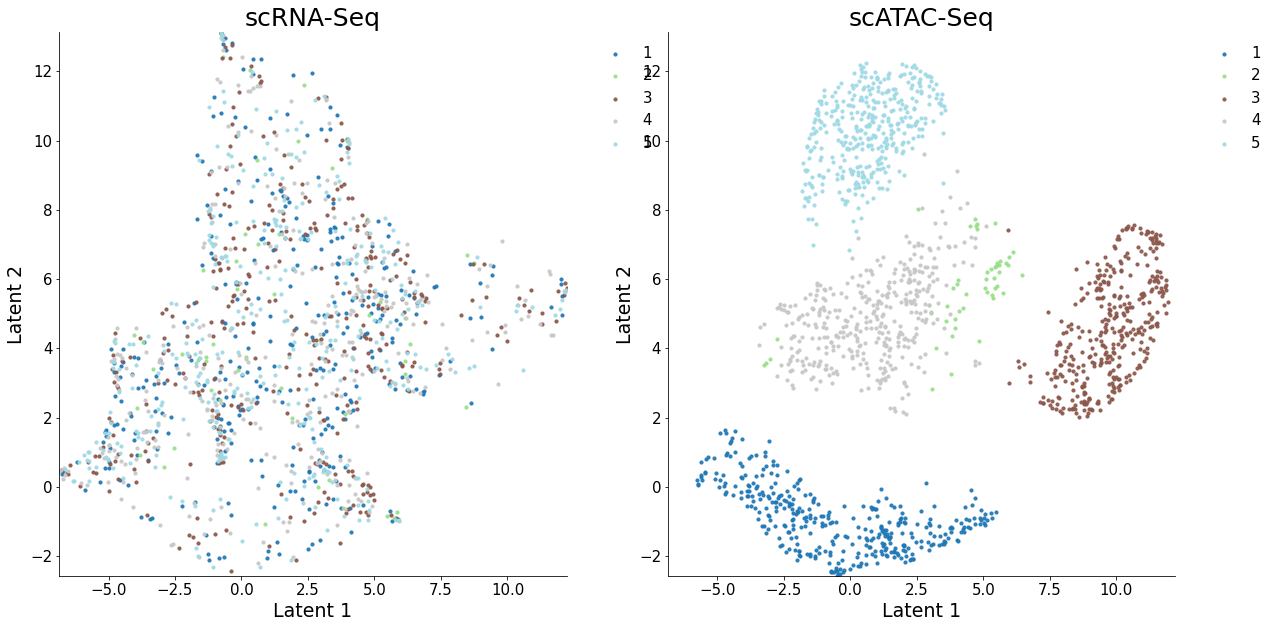

In [13]:
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

In [15]:
# # binarize
# z_rna = model.softmax(model.C_1.detach()).numpy()
# z_atac = model.softmax(model.C_2.detach()).numpy()

# ind_rna = np.zeros_like(z_rna)
# ind_atac = np.zeros_like(z_atac)
# ind_rna[np.arange(z_rna.shape[0]),max_rna] = 1
# ind_atac[np.arange(ind_atac.shape[0]),max_atac] = 1

None


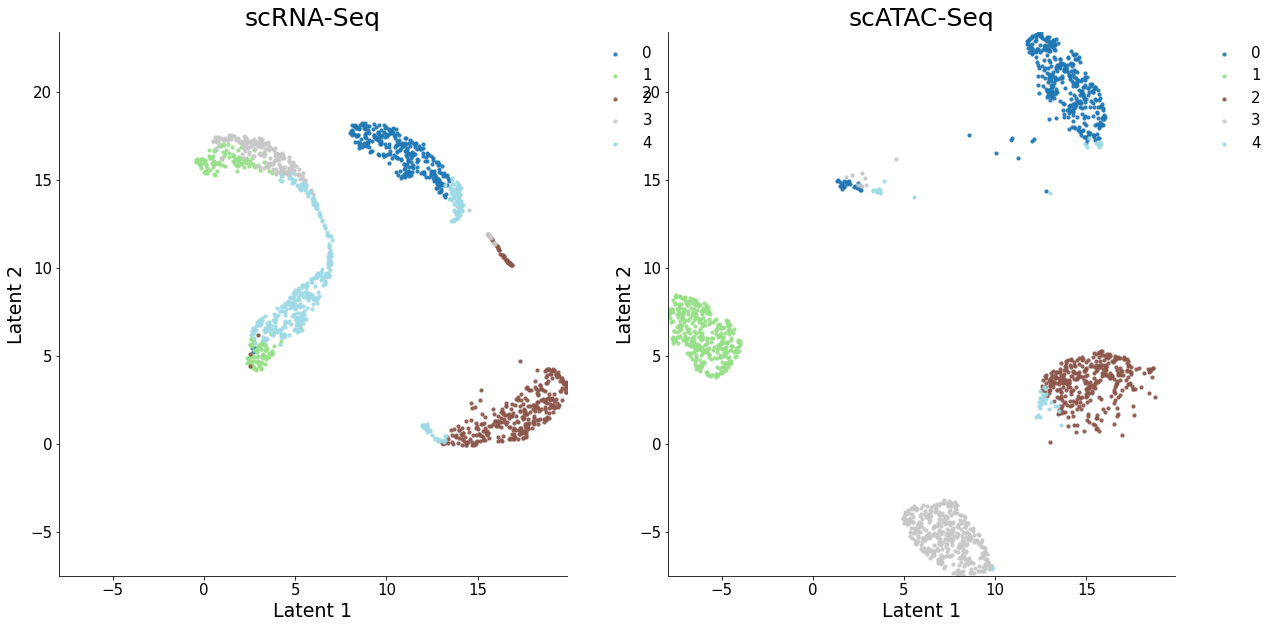

In [16]:
utils.plot_latent(z_rna, z_atac, max_rna, max_atac, mode= "separate", save = None)

In [152]:
z_rna = model.softmax(model.C_1.detach())
z_atac = model.softmax(model.C_2.detach())

z_rna, z_atac = utils.match_alignment(z_rna = z_rna, z_atac = z_atac, k = 3)
# z_atac, z_rna = utils.match_alignment(z_rna = z_atac, z_atac = z_rna, k = 10)

z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

None


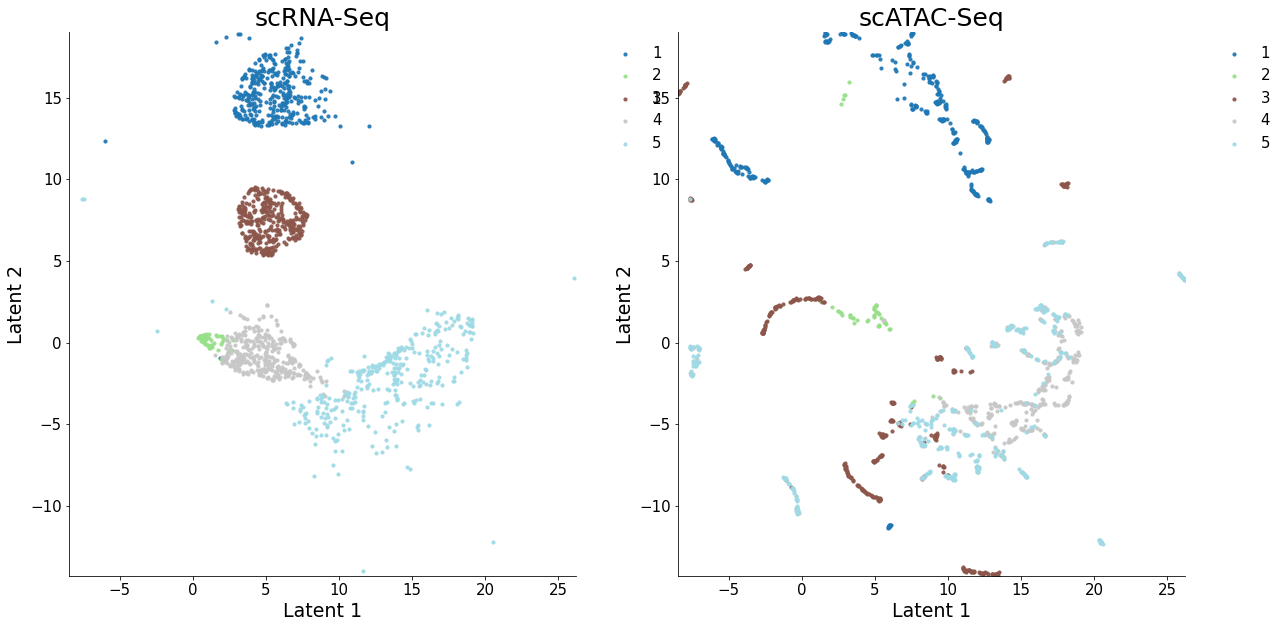

In [153]:
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

None


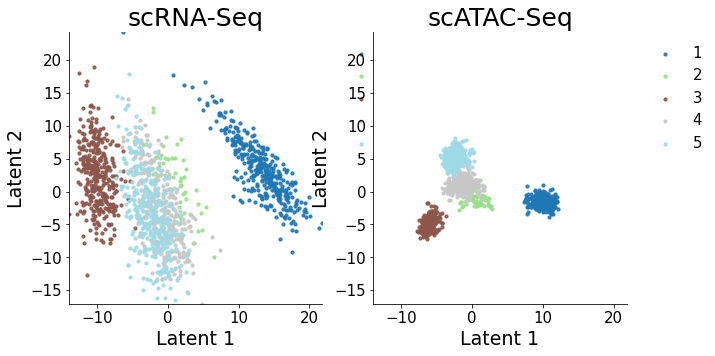

In [40]:
pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z_rna = pca_op.fit_transform(model.G.detach().numpy())
z_atac = pca_op.fit_transform(model.R.detach().numpy())

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None, figsize = (10,5))

In [41]:
from scipy.sparse import csr_matrix, linalg
def svd_fast(X, n_pcs = 2):
    U, Sigma, Vh = linalg.svds(X, return_singular_vectors = "u", k = n_pcs, which = "LM")
    return U

In [42]:
z_rna = svd_fast(model.G.detach().numpy())
z_atac = svd_fast(model.R.detach().numpy())

None


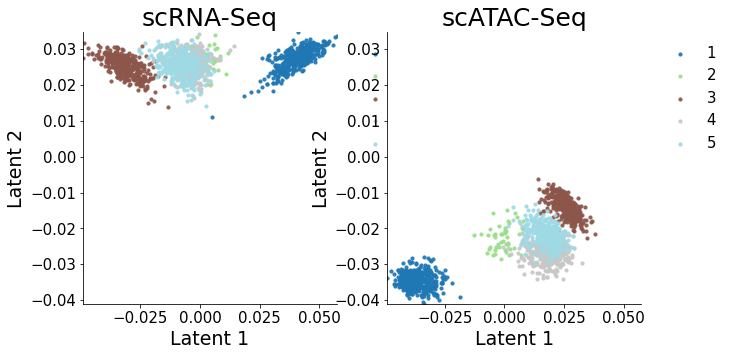

In [43]:
label_rna = model.meta_rna["pop"].values[:,None]
label_atac = model.meta_atac["pop"].values[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None, figsize = (10,5))

In [44]:
class cfrmModel(Module):
    def __init__(self, dir, N=3, batch_size=100, lr=1e-3, dropout=0.1, init = "random"):
        super().__init__()
        self.N = N
        self.batch_size = batch_size
        self.alpha = torch.FloatTensor([1, 1, 1])
        # data
        counts_rna = pd.read_csv(dir + "GxC1.txt", sep = "\t", header = None).values.T
        counts_atac = pd.read_csv(dir + "RxC2.txt", sep = "\t", header = None).values.T
        gact = pd.read_csv(dir + "region2gene.txt", sep = "\t", header = None).values

        counts_rna = utils.preprocess(counts_rna, mode = "quantile", modality = "RNA")
        counts_atac = utils.preprocess(counts_atac, mode = "quantile", modality = "ATAC")
        gact = utils.preprocess(gact, mode = "gact")
#         counts_rna = counts_rna/np.sum(counts_rna, axis = 1)[:,None]
#         counts_atac = counts_atac/np.sum(counts_atac, axis = 1)[:,None]

        self.G = torch.FloatTensor(counts_rna)
        self.R = torch.FloatTensor(counts_atac)
        self.A = torch.FloatTensor(gact)

        # learnable parameters
        if init == "svd":
            u_g, s_g, v_g = torch.svd(self.G)
            self.C_1 = u_g[:, :N]
            self.C_g = v_g[:, :N]        

            u_r, s_r, v_r = torch.svd(self.R)
            self.C_2 = u_r[:, :N]
            self.C_r = v_r[:, :N]

        if init == "random":
            self.C_1, _ = torch.qr(torch.randn((self.G.shape[0],N)))
            self.C_2, _ = torch.qr(torch.randn((self.R.shape[0],N)))
            self.C_g, _ = torch.qr(torch.randn((self.G.shape[1],N)))
            self.C_r, _ = torch.qr(torch.randn((self.R.shape[1],N)))


        self.A_1g = self.C_1.t() @ self.G @ self.C_g
        self.A_2r = self.C_2.t() @ self.R @ self.C_r
        self.A_rg = self.C_r.t() @ self.A @ self.C_g

        loss = self.loss()
        for l in loss:
            print(l.item())
        
       
    def loss(self):
        loss1 = (self.G - self.C_1 @ self.A_1g @ self.C_g.t()).pow(2).mean()
        loss2 = (self.R - self.C_2 @ self.A_2r @ self.C_r.t()).pow(2).mean()
        loss3 = (self.A - self.C_r @ self.A_rg @ self.C_g.t()).pow(2).mean()
        loss = self.alpha[0] * loss1 + self.alpha[1] * loss2 + self.alpha[2] * loss3

        return loss, self.alpha[0] * loss1, self.alpha[1] * loss2, self.alpha[2] * loss3

    def train_func(self, T):
        for t in range(T):
            for mode in ['C_1', 'C_2', 'C_r', 'C_g']:
                if mode == 'C_1':
                    M = self.alpha[0] * (self.G @ self.C_g @ self.C_g.t() @ self.G.t())
                    s_g, u_g = torch.eig(M, eigenvectors=True)
                    self.C_1 = u_g[:, :self.N]

                elif mode == 'C_2':
                    M = self.alpha[1] * (self.R @ self.C_r @ self.C_r.t() @ self.R.t())
                    s_g, u_g = torch.eig(M, eigenvectors=True)
                    self.C_2 = u_g[:, :self.N]

                elif mode == 'C_r':
                    M = self.alpha[1] * (self.R.t() @ self.C_2 @ self.C_2.t() @ self.R) + self.alpha[2] * (self.A @ self.C_g @ self.C_g.t() @ self.A.t())
                    s_g, u_g = torch.eig(M, eigenvectors=True)
                    self.C_r = u_g[:, :self.N]

                elif mode == 'C_g':
                    M = self.alpha[0] * (self.G.t() @ self.C_1 @ self.C_1.t() @ self.G) + self.alpha[2] * (self.A.t() @ self.C_r @ self.C_r.t() @ self.A)
                    s_g, u_g = torch.eig(M, eigenvectors=True)
                    self.C_g = u_g[:, :self.N]
            
            self.A_1g = self.C_1.t() @ self.G @ self.C_g
            self.A_2r = self.C_2.t() @ self.R @ self.C_r
            self.A_rg = self.C_r.t() @ self.A @ self.C_g
            
            loss, loss1, loss2, loss3 = self.loss()
            print('Epoch {}, Training Loss: {:.4f}'.format(t+1, loss.item()))
            info = [
                'loss RNA: {:.5f}'.format(loss1.item()),
                'loss ATAC: {:.5f}'.format(loss2.item()),
                'loss gene act: {:.5f}'.format(loss3.item())
            ]
            for i in info:
                print("\t", i)

                    


In [45]:
model = cfrmModel(dir = '../data/simulated/2b5c_ziqi1/', N=3, batch_size = 512, init = "svd")
model.train_func(T=100)

0.39255449175834656
0.3472805917263031
0.0450749546289444
0.000198934183572419
Epoch 1, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020
Epoch 2, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020
Epoch 3, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020
Epoch 4, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020
Epoch 5, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020
Epoch 6, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020
Epoch 7, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020
Epoch 8, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020
Epoch 9, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020
Epoch 10, Training Loss: 0.3926
	 loss RNA: 0.34

Epoch 84, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020
Epoch 85, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020
Epoch 86, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020
Epoch 87, Training Loss: 0.3926
	 loss RNA: 0.34728
	 loss ATAC: 0.04507
	 loss gene act: 0.00020


KeyboardInterrupt: 

In [46]:
# torch.save(model, "b2c6.pth")
# model = torch.load("b2c6.pth")
from umap import UMAP

pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

In [50]:
dir = '../data/simulated/2b5c_ziqi1/'
meta_rna = pd.read_csv(os.path.join(dir, "cell_label1.txt"), sep = "\t")
meta_atac = pd.read_csv(os.path.join(dir, "cell_label2.txt"), sep = "\t")
label_rna = meta_rna["pop"].values[:,None]
label_atac = meta_atac["pop"].values[:,None]

None


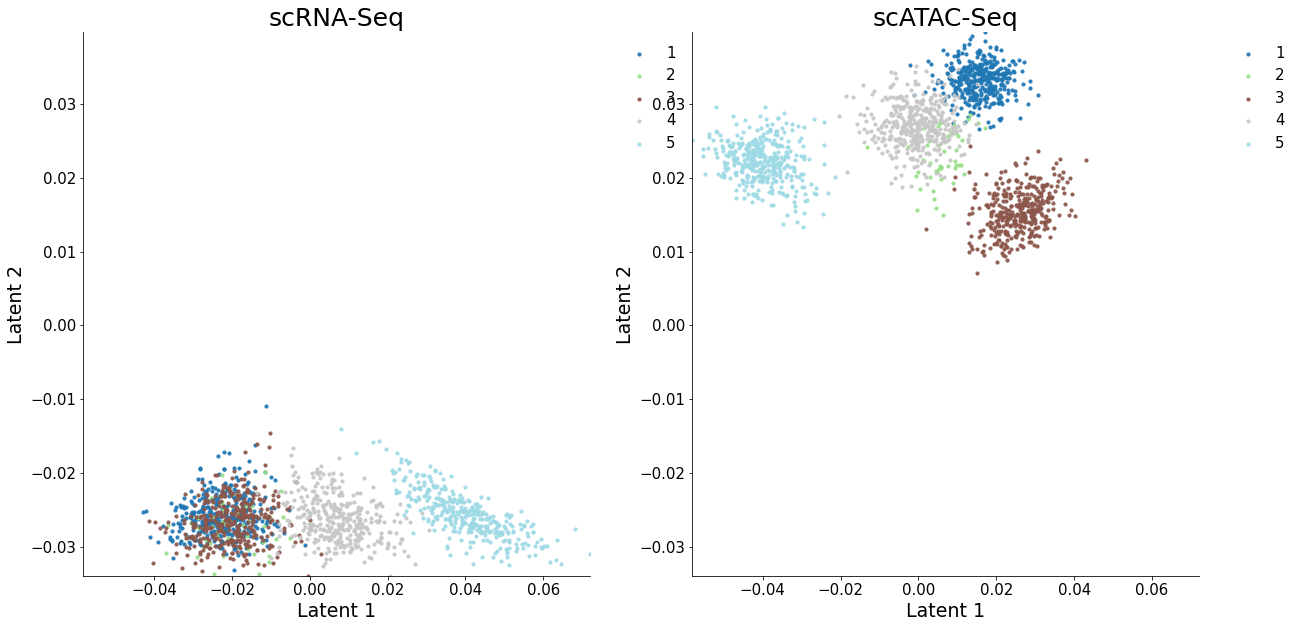

In [51]:
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

In [27]:
model = cfrmModel(dir = '../data/simulated/2batches_3clusts', N=3, dropout=0, init = "svd")
model.train_func(T=1000)

0.2704484164714813
0.2241944968700409
0.04583536460995674
0.0004185508587397635
Epoch 1, Training Loss: 0.2704
	 loss RNA: 0.22419
	 loss ATAC: 0.04584
	 loss gene act: 0.00042
Epoch 2, Training Loss: 0.2704
	 loss RNA: 0.22419
	 loss ATAC: 0.04584
	 loss gene act: 0.00042
Epoch 3, Training Loss: 0.2704
	 loss RNA: 0.22419
	 loss ATAC: 0.04584
	 loss gene act: 0.00042
Epoch 4, Training Loss: 0.2704
	 loss RNA: 0.22419
	 loss ATAC: 0.04584
	 loss gene act: 0.00042
Epoch 5, Training Loss: 0.2704
	 loss RNA: 0.22419
	 loss ATAC: 0.04584
	 loss gene act: 0.00042


KeyboardInterrupt: 

None


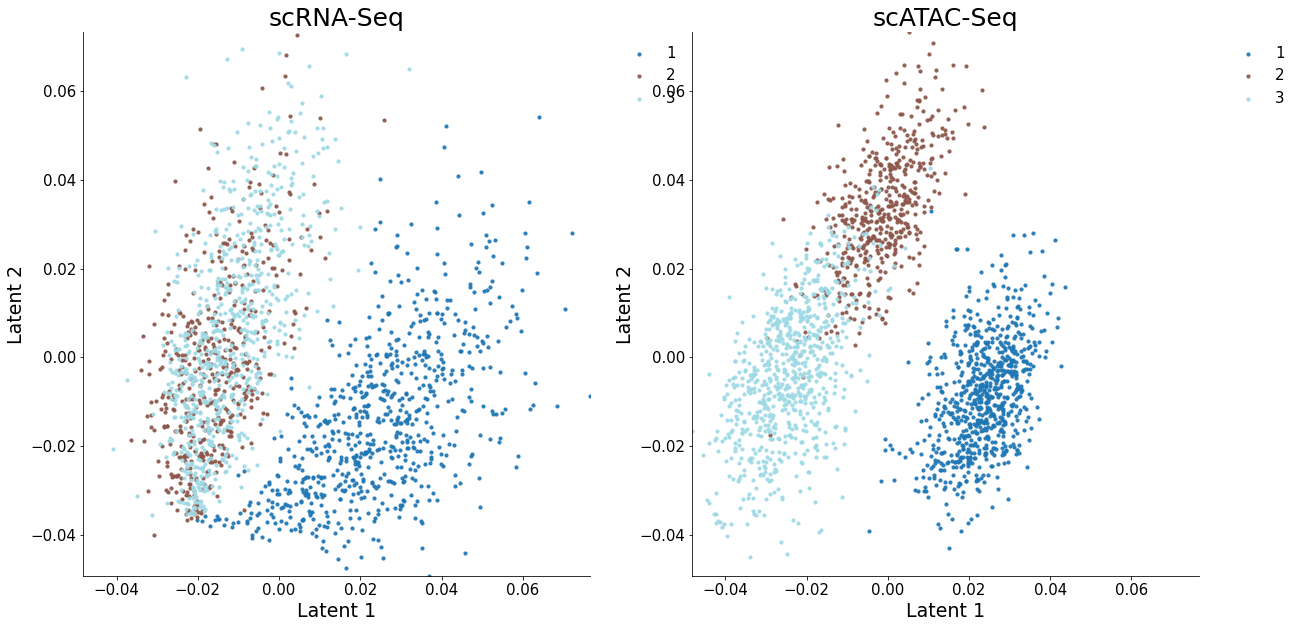

In [28]:
# torch.save(model, "b2c6.pth")
# model = torch.load("b2c6.pth")
from umap import UMAP

pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

In [29]:
model = cfrmModel(dir = '../data/simulated/2batches_6clusts', N=3, dropout=0, init = "random")
model.train_func(T=100)

1.1414905786514282
1.0413411855697632
0.09973078221082687
0.0004186659352853894
Epoch 1, Training Loss: 0.3652
	 loss RNA: 0.28159
	 loss ATAC: 0.08321
	 loss gene act: 0.00042
Epoch 2, Training Loss: 0.2638
	 loss RNA: 0.21496
	 loss ATAC: 0.04846
	 loss gene act: 0.00042
Epoch 3, Training Loss: 0.2599
	 loss RNA: 0.21157
	 loss ATAC: 0.04789
	 loss gene act: 0.00042
Epoch 4, Training Loss: 0.2596
	 loss RNA: 0.21145
	 loss ATAC: 0.04776
	 loss gene act: 0.00042
Epoch 5, Training Loss: 0.2596
	 loss RNA: 0.21144
	 loss ATAC: 0.04771
	 loss gene act: 0.00042
Epoch 6, Training Loss: 0.2595
	 loss RNA: 0.21144
	 loss ATAC: 0.04767
	 loss gene act: 0.00042
Epoch 7, Training Loss: 0.2595
	 loss RNA: 0.21144
	 loss ATAC: 0.04764
	 loss gene act: 0.00042
Epoch 8, Training Loss: 0.2595
	 loss RNA: 0.21144
	 loss ATAC: 0.04763
	 loss gene act: 0.00042
Epoch 9, Training Loss: 0.2595
	 loss RNA: 0.21144
	 loss ATAC: 0.04761
	 loss gene act: 0.00042
Epoch 10, Training Loss: 0.2595
	 loss RNA: 0.2

KeyboardInterrupt: 

None


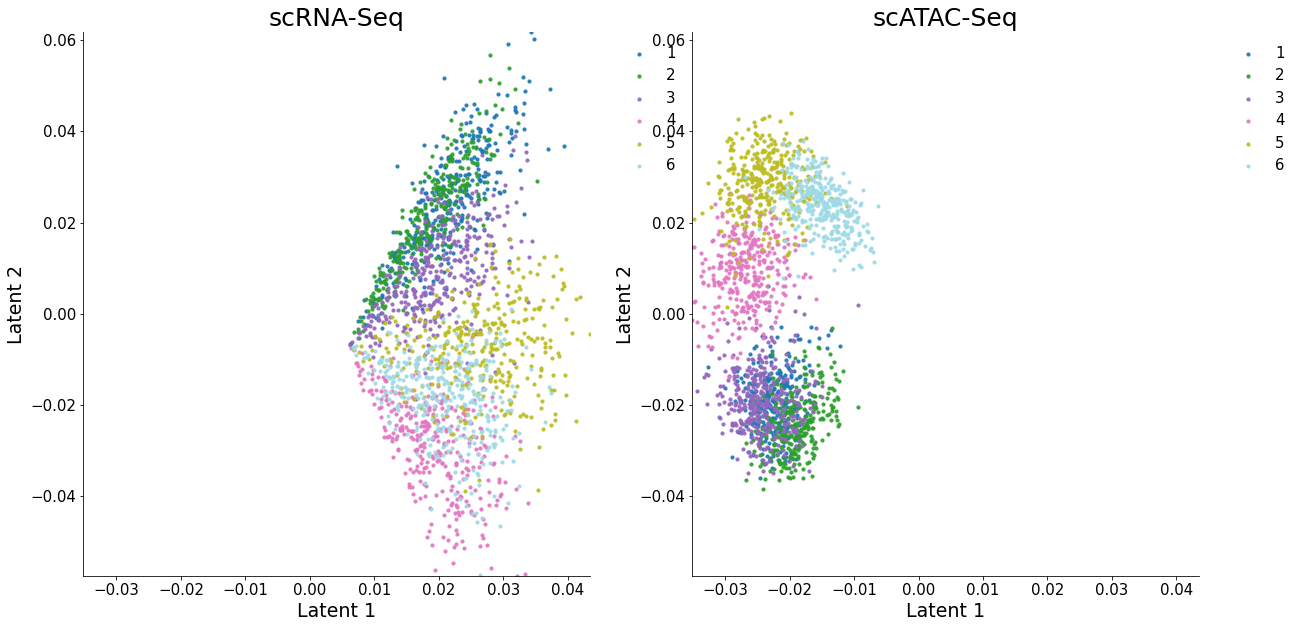

In [30]:
# torch.save(model, "b2c6.pth")
# model = torch.load("b2c6.pth")
from umap import UMAP

pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

In [31]:
model = cfrmModel(dir = '../data/simulated/2batches_6clusts', N=3, dropout=0, init = "svd")
model.train_func(T=100)

0.25944381952285767
0.21143664419651031
0.04758860915899277
0.0004185651778243482
Epoch 1, Training Loss: 0.2594
	 loss RNA: 0.21144
	 loss ATAC: 0.04759
	 loss gene act: 0.00042
Epoch 2, Training Loss: 0.2594
	 loss RNA: 0.21144
	 loss ATAC: 0.04759
	 loss gene act: 0.00042
Epoch 3, Training Loss: 0.2594
	 loss RNA: 0.21144
	 loss ATAC: 0.04759
	 loss gene act: 0.00042
Epoch 4, Training Loss: 0.2594
	 loss RNA: 0.21144
	 loss ATAC: 0.04759
	 loss gene act: 0.00042
Epoch 5, Training Loss: 0.2594
	 loss RNA: 0.21144
	 loss ATAC: 0.04759
	 loss gene act: 0.00042
Epoch 6, Training Loss: 0.2594
	 loss RNA: 0.21144
	 loss ATAC: 0.04759
	 loss gene act: 0.00042


KeyboardInterrupt: 

None


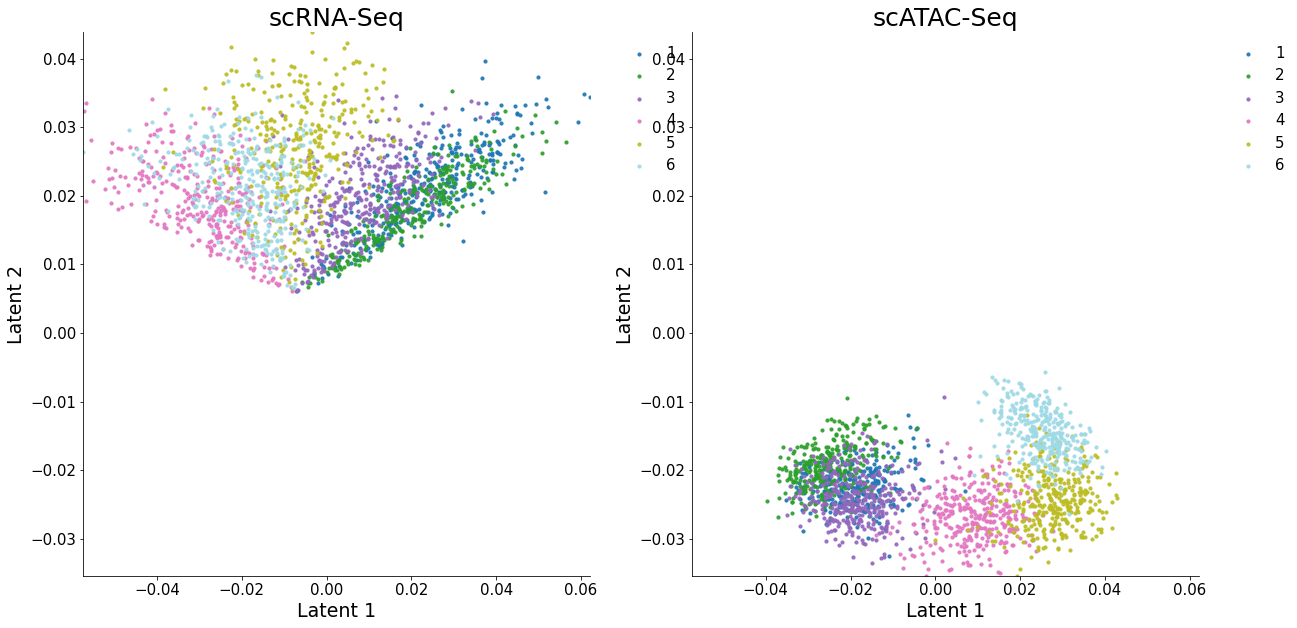

In [32]:
# torch.save(model, "b2c6.pth")
# model = torch.load("b2c6.pth")
from umap import UMAP

pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)